In [2]:
import numpy as np
import tensorflow as tf
import sklearn as sk
import sklearn.linear_model as sklm
import sklearn.metrics as skmt
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage.io
import h5py
import sys
import os
import gc

sys.path.append('../Metric/')
sys.path.append('../../Visualization/')
sys.path.append('../../Data_Preprocessing//')
from Metric import *
from Visualization import *
from Data_Extractor import *
from Restored_Classifier import *
from sklearn.externals import joblib

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# settings
path_image_dir = "../../Data/090085/"
path_road_mask = "../../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/road_mask.tif"

if not path_image_dir.endswith('/'): path_image_dir = path_image_dir + '/'

# sk-SGD_weight_m5_p1_e15_r1  
# sk-SGD_weight_G0.0001_p0_e15_rNone
# Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_p0_e20_r0
classifier_type = 'FCN'
path_model_dir = "../Segmentation-FCN/Result/FCN/FCN_64-128-256_1_cat1-32;3-32|1-32;3-32_weight_G_x1_p0_e25_r0/"
model_name = "FCN_64-128-256_1_cat1-32;3-32|1-32;3-32_weight_G_x1_p0_e25_r0-19"
size = 128
step = 7

path_pred_dir = "./Result/Pred/All"
if not path_pred_dir.endswith('/'): path_pred_dir = path_pred_dir + '/'
path_pred_result = path_pred_dir + model_name + '.h5'
print(path_pred_result)

use_norm = True
if model_name.find("_G") > 0:
    norm = "Gaussian"
elif model_name.find("_m") > 0:
    norm = "mean"
else:
    norm = None
    use_norm = False

./Result/Pred/All/FCN_64-128-256_1_cat1-32;3-32|1-32;3-32_weight_G_x1_p0_e25_r0-19.h5


In [4]:
# re-load classifier
classifier = Classifier(path_model_dir, model_name, classifier_type)

INFO:tensorflow:Restoring parameters from ../Segmentation-FCN/Result/FCN/FCN_64-128-256_1_cat1-32;3-32|1-32;3-32_weight_G_x1_p0_e25_r0/FCN_64-128-256_1_cat1-32;3-32|1-32;3-32_weight_G_x1_p0_e25_r0-19


In [ ]:
# get date list
date_list = ['20170531']

# check prediction not existing
h5f = h5py.File(path_pred_result, 'a')
print('already have: ', set([pred for pred in h5f.keys()]))
h5f.close()

for date in date_list:

    # check prediction not existing
    h5f = h5py.File(path_pred_result, 'r')
    if date in set([pred for pred in h5f.keys()]):
        print(date, 'already predicted, skip')
        h5f.close()
        continue
    else:
        print('predicting', date)
        h5f.close()
    
    # load raw image
    path_image = path_image_dir + '090085_' + date + '.h5'
    h5f = h5py.File(path_image, 'r')
    raw_image = np.array(h5f['scene'])
    h5f.close()
    
    # construct extractor
    data_extractor = Pred_Data_Extractor(raw_image, step=step, size=size,
                                         normalization=norm, classifier_type=classifier_type)
    
    # pred on image
    if classifier_type == 'LR':
        pred_road = np.zeros(shape=raw_image[0].shape)
        print(pred_road.shape, date)

        for coord, patch in data_extractor.iterate_raw_image_patches_with_coord(norm=use_norm):
            pred_road[coord[0]+int(size/2),coord[1]+int(size/2)] = classifier.predict(patch)

    else: # FCN        
        pred_road = np.zeros(shape=(raw_image.shape[1], raw_image.shape[2], 2))
        print(pred_road.shape, date)

        for coord, patch in data_extractor.iterate_raw_image_patches_with_coord(norm=use_norm):
            pred_road[coord[0]:coord[0]+size, coord[1]:coord[1]+size] += classifier.predict(patch)
            
    # save prediction
    h5f = h5py.File(path_pred_result, 'a')
    h5f.create_dataset(name=date, data=pred_road)
    h5f.close()

Analyze pred along the time

In [5]:
def get_patch(coord, mask, size):
    return mask[coord[0]:coord[0]+size, coord[1]:coord[1]+size]

def load_raw_and_pred(path_image, path_pred_in_time, date, classifier_type):
    # load prediction 
    h5f = h5py.File(path_pred_in_time, 'r')
    pred_road = np.array(h5f[date])
    h5f.close()
    
    if classifier_type == 'FCN':
        pred_road, invalid_pred_mask = pred_normalization(pred_road)

    # load raw image
    h5f = h5py.File(path_image, 'r')
    raw_image = np.array(h5f['scene'][date])
    h5f.close()
    
    return raw_image, pred_road, invalid_pred_mask

#######################################################

def pred_normalization(pred):
    pred_norm = pred[:,:,1]/pred.sum(axis=-1)
    invalid_mask = pred_norm != pred_norm
    
    pred_norm[np.where(invalid_mask)] = 0
    pred_norm[np.where(pred_norm == np.float('inf'))] = 1
    
    return pred_norm, invalid_mask

# softmax
def pred_softmax(pred):
    threshold = 500
    pred_exp = pred.copy()
    inf_idx = np.where(pred_exp > threshold)
    
    for x, y in zip(inf_idx[0], inf_idx[1]):
        while((pred_exp[x,y] > threshold).any()):
            pred_exp[x,y] = pred_exp[x,y] / 10
    pred_exp = np.exp(pred_exp[:,:,1])/np.exp(pred_exp).sum(axis=-1)
    pred_exp[np.where(pred[:,:,1] == 0)] = 0 # softmax([0,0]) = (0.5, 0.5)
    return pred_exp

def get_log_pred(pred):
    log_pred = -np.log(-pred + 1 + 1e-9)
    norm_log_pred = (log_pred - log_pred.min()) / (log_pred.max()-log_pred.min())
    return norm_log_pred

#######################################################

def time_diff(img_old, img_new):
    img_diff = img_new - img_old
    if len(img_diff.shape) == 2:
        img_diff = (img_diff - img_diff.min()) / (img_diff.max() - img_diff.min())
    else:
        for band_idx in range(img_diff.shape[0]):
            img_diff[band_idx] = (img_diff[band_idx] - img_diff[band_idx].min()) / (img_diff[band_idx].max() - img_diff[band_idx].min())
    
    img_diff[np.where(img_diff != img_diff)] = 0    
    return img_diff

def average_in_year(path_image, path_pred_in_time, date_list, year, raw_shape, road_shape):
    valid_road_cnt = np.zeros(shape=road_shape)
    pred_road = np.zeros(shape=road_shape)
    valid_raw_cnt = np.zeros(shape=raw_shape)
    raw_image = np.zeros(shape=raw_shape)
    
    for date in date_list:
        if year not in date: continue
        
        cur_raw, cur_pred, cur_invalid_pred = load_raw_and_pred(path_image, path_pred_in_time, 
                                                                date, classifier_type)
        
        valid_idx = np.where(cur_invalid_pred == 0)
        valid_road_cnt[valid_idx] = valid_road_cnt[valid_idx] + 1
        pred_road[valid_idx] = pred_road[valid_idx] + cur_pred[valid_idx]
        
        valid_idx = np.where(cur_raw != -9999)
        valid_raw_cnt[valid_idx] = valid_raw_cnt[valid_idx] + 1
        raw_image[valid_idx] = raw_image[valid_idx] + cur_raw[valid_idx]
        gc.collect()
    
    pred_road = pred_road/valid_road_cnt
    raw_image = raw_image/valid_raw_cnt

    invalid_idx = np.where(valid_road_cnt == 0)
    pred_road[invalid_idx] = 0
    invalid_idx = np.where(valid_raw_cnt == 0)
    raw_image[invalid_idx] = -9999
    
    return raw_image, pred_road

In [6]:
# configure visualisation setting

# get date list
# h5f = h5py.File(path_pred_result, 'r')
# date_list = sorted([i for i in h5f.keys()], key= lambda x:x)
# h5f.close()
date = '20170531'

# load road mask
road_mask = skimage.io.imread(path_road_mask)

# load raw image
path_image = path_image_dir + '090085_' + date + '.h5'
h5f = h5py.File(path_image, 'r')
raw_image = np.array(h5f['scene'])
h5f.close()

# load & normalise pred
h5f = h5py.File(path_pred_result, 'r')
pred_road = np.array(h5f[date])
h5f.close()

norm_pred, _ = pred_normalization(pred_road)

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
post_pred = norm_pred**2
pred_weight = 0.4
post_fix = '_square_'+str(pred_weight).replace('.', '_')

gc.collect()
figsize = (20,20)

plt.close('all')
save_path=path_pred_dir + 'raw_pred_with_road/' + model_name + post_fix + '.png'
show_pred_prob_with_raw(raw_image, post_pred, road_mask, pred_weight=pred_weight, figsize=figsize, 
                        show_plot=False, save_path=save_path)

plt.close('all')
gc.collect()
save_path=path_pred_dir+ 'raw_pred/' + model_name + post_fix + '.png'
show_pred_prob_with_raw(raw_image, post_pred, pred_weight=pred_weight, figsize=figsize, 
                        show_plot=False, save_path=save_path)

# plt.close('all')
# plt.figure(figsize=(150,150))
# plt.imshow(post_pred)
# plt.axis('off')
# save_path=path_pred_dir + 'only_pred/' + model_name + post_fix + '.png'
# plt.savefig(save_path, bbox_inches='tight')

gc.collect()

Crop same patch from multiple prediction

./Result/Pred/All/FCN_64-128-256_1_cat1-32;3-32|1-32;3-32_weight_G_x1_p0_e25_r0-19.h5


/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


./Result/Pred/All/Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_p0_e20_r0.h5
./Result/Pred/All/sk-SGD_weight_G0_0001_p0_e15_rNone.h5


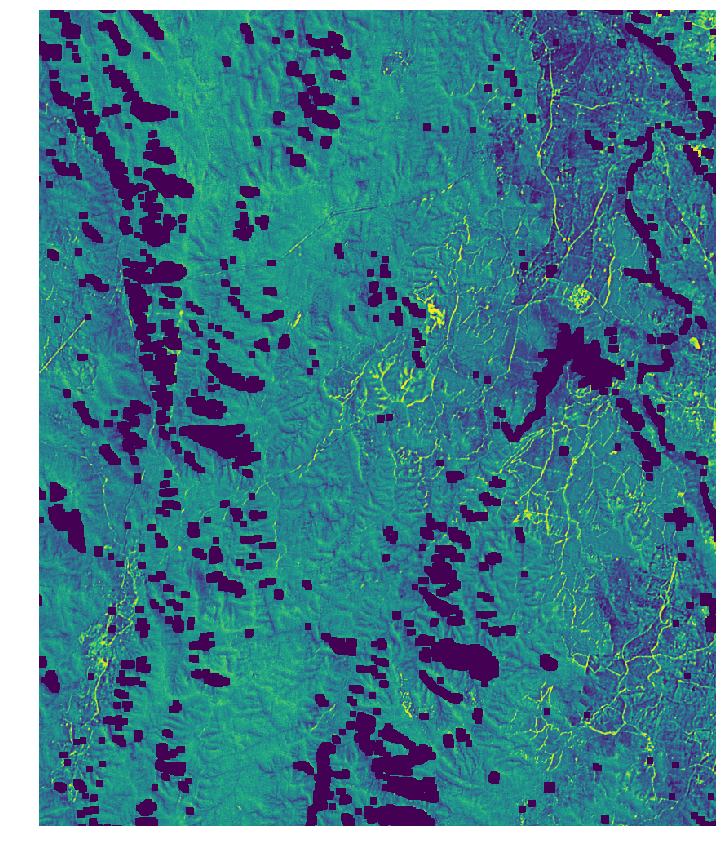

In [7]:
path_pred_dir = "./Result/Pred/All/"

model_list = ['FCN_64-128-256_1_cat1-32;3-32|1-32;3-32_weight_G_x1_p0_e25_r0-19',
              'Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_p0_e20_r0',
              'sk-SGD_weight_G0_0001_p0_e15_rNone']
pred_weight_list = [0.4, 0.5, 2.5]
post_process_list = [lambda x:x**2, lambda x:x**2, get_log_pred]
figsize = (15,15)

for model_name, pred_weight, post_process in zip(model_list, pred_weight_list, post_process_list):
    path_pred_result = path_pred_dir + model_name + '.h5'
    print(path_pred_result)
    
    h5f = h5py.File(path_pred_result, 'r')
    pred_road = np.array(h5f['20170531'])
    h5f.close()
    if 'sk-SGD_' not in model_name:
        pred_road, _ = pred_normalization(pred_road)
    post_pred = post_process(pred_road)
    gc.collect()

    if 'FCN' in model_name: model_name = 'Unet'
    elif 'Incep' in model_name: model_name = 'FCN'
    elif 'sk-SGD' in model_name: model_name = 'LR'
    
    for x,y,x_size,y_size,post_fix in [(615,3185,865,835,'_CBR'), (820,1900,1000,830,'_field')]:
    
        cur_raw  = raw_image[:,x:x+x_size, y:y+y_size]
        cur_pred = post_pred[x:x+x_size, y:y+y_size]
        cur_mask = road_mask[x:x+x_size, y:y+y_size]
                
        plt.close('all')
        save_path=path_pred_dir + 'sample/' + model_name + post_fix + '.png'
        show_pred_prob_with_raw(cur_raw, cur_pred, cur_mask, pred_weight=pred_weight, figsize=figsize, 
                                show_plot=False, save_path=save_path)

        plt.close('all')
        save_path=path_pred_dir+ 'sample/' + model_name + post_fix + '_pred.png'
        show_pred_prob_with_raw(cur_raw, cur_pred, pred_weight=pred_weight, figsize=figsize, 
                                show_plot=False, save_path=save_path)

        plt.close('all')
        plt.figure(figsize=figsize)
        plt.imshow(cur_pred)
        plt.axis('off')
        save_path=path_pred_dir + 'sample/' + model_name + post_fix + '_pred_only.png'
        plt.savefig(save_path, bbox_inches='tight')
#         plt.show()

        plt.close('all')
        plt.figure(figsize=figsize)
        plt.imshow(pred_road[x:x+x_size, y:y+y_size])
        plt.axis('off')
        save_path=path_pred_dir + 'sample/' + model_name + post_fix + '_pred_only_origin.png'
        plt.savefig(save_path, bbox_inches='tight')
#         plt.show()

In [13]:
figsize = (20,20)
for x,y,x_size,y_size,post_fix in [(615,3185,865,835,'_CBR'), (820,1900,1000,830,'_field')]:

    cur_raw  = raw_image[:,x:x+x_size, y:y+y_size]
    cur_mask = road_mask[x:x+x_size, y:y+y_size]
    
    plt.close('all')
    save_path=path_pred_dir + 'sample/' + 'raw_image' + post_fix + '.png'
    show_raw_image(cur_raw, size=-1, figsize=figsize, 
                   show_plot=False, save_path=save_path)
    
    plt.close('all')
    plt.figure(figsize=figsize)
    plt.imshow(cur_mask)
    plt.axis('off')
    save_path=path_pred_dir + 'sample/' + 'road' + post_fix + '_ground_truth.png'
    plt.savefig(save_path, bbox_inches='tight')
    
    plt.close('all')
    save_path=path_pred_dir + 'sample/' + 'truth_on' + post_fix + '.png'
    show_pred_road_against_raw(cur_raw, cur_mask, figsize=figsize, show_plot=False, save_path=save_path)
#         plt.show()

In [ ]:
post_pred = norm_pred**2
pred_weight = 0.4
post_fix = '_square_'+str(pred_weight).replace('.', '_')

gc.collect()

x = 1820
y = 1900
x_size=1000 # vertical
y_size = 830 # horizontal
x = x-x_size

# plt.close('all')
# save_path=path_pred_dir + 'raw_pred_with_road/' + model_name + post_fix + '.png'
# show_pred_prob_with_raw(raw_image, post_pred, road_mask, pred_weight=pred_weight, figsize=(150,150), 
#                         show_plot=False, save_path=save_path)

plt.close('all')
gc.collect()
save_path=path_pred_dir+ 'raw_pred/' + model_name + post_fix + '.png'
show_pred_prob_with_raw(raw_image[:,x:x+x_size, y:y+y_size], post_pred[x:x+x_size, y:y+y_size], road_mask[x:x+x_size, y:y+y_size],
                        pred_weight=pred_weight,figsize=(50,50), 
                        show_plot=True, save_path=None)

# plt.close('all')
# plt.figure(figsize=(50,50))
# plt.imshow(post_pred[x:x+x_size,y:y+y_size], cmap='gray')
# plt.axis('off')
# save_path=path_pred_dir + 'only_pred/' + model_name + post_fix + '.png'
# # plt.savefig(save_path, bbox_inches='tight')
# plt.show()

# plt.close('all')
# plt.figure(figsize=(50,50))
# plt.imshow(norm_pred[x:x+x_size,y:y+y_size], cmap='gray')
# plt.axis('off')
# save_path=path_pred_dir + 'only_pred/' + model_name + post_fix + '.png'
# # plt.savefig(save_path, bbox_inches='tight')
# plt.show()

# plt.close('all')
# plt.figure(figsize=(50,50))
# plt.imshow(road_mask[x:x+x_size,y:y+y_size], cmap='gray')
# plt.axis('off')
# save_path=path_pred_dir + 'only_pred/' + model_name + post_fix + '.png'
# # plt.savefig(save_path, bbox_inches='tight')
# plt.show()

gc.collect()

In [ ]:
x = 1820
y = 1900
x_size=1000 # vertical
y_size = 830 # horizontal
x = x-x_size


In [ ]:
print(x,y,x_size, y_size)